In [40]:
import requests
from datetime import datetime
import spacy
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import  PorterStemmer, WordNetLemmatizer
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt

class G2ProductFeatureList():
    
    def __init__(self,token):
        self.review_dict = {}
        self.likes_dict = {}
        self.nlp_model = spacy.load("en_core_web_lg")
        self.token = token
        self.feature_dict = {}
        self.clusters = {}
        self.top_features_per_cluster = {}
        self.url = "https://data.g2.com/api/v1/survey-responses"
    
    
    def fetch_review_from_a_page(self, number_of_reviews=10, page_num=1):
        
        headers = {
            "Authorization": f"Token token={self.token}",
            "Content-Type": "application/vnd.api+json"
        }        
        params = {
            "page[size]": f"{number_of_reviews}",
            "page[number]": f"{page_num}"  
        }

        response = requests.get(self.url, headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            return data['data']
        else:
            print(f"Error: {response.status_code} - {response.text}")
            return None
    
    
    def fetch_all_reviews(self):
        all_reviews = []
        page_num = 1
        while True:
            reviews = self.fetch_review_from_a_page(number_of_reviews=100, page_num=page_num)
            if not reviews:
                break
            all_reviews.extend(reviews)
            page_num += 1
        return all_reviews
        
    
    def change_to_dd_mm_yyyy(self,rfc3339_date):
        dt_object = datetime.fromisoformat(rfc3339_date)
        return dt_object.strftime('%d%m%Y')


    def add_to_review_dict(self,review):
            
        attributes = review["attributes"]
        review_id = review["id"]
        try:
            self.review_dict[review_id] = {
                "ease_of_doing_business_with": attributes["secondary_answers"].get("ease_of_doing_business_with", {}).get("value"),
                "country_name": attributes["country_name"],
                "votes_up": attributes["votes_up"],
                "votes_down": attributes["votes_down"],
                "votes_total": attributes["votes_total"],
                "star_rating": attributes["star_rating"],
                "time": self.change_to_dd_mm_yyyy(attributes["submitted_at"]),
                "likes": attributes["comment_answers"]["love"]["value"],
                "dislikes": attributes["comment_answers"]["hate"]["value"],
                "date": attributes["updated_at"]
            }
        except Exception as e:
           pass
    
    def create_review_dictionary(self, num_of_reviews=None, page=None):
        if num_of_reviews is None and page is None:
            fetched_reviews = self.fetch_all_reviews()
        else:
            fetched_reviews = self.fetch_review_from_a_page(number_of_reviews=num_of_reviews, page_num=page)
        
        for review in fetched_reviews:
            self.add_to_review_dict(review)

    
    def change_name(self,sentence):
        nlp = self.nlp_model
        doc = nlp(sentence)
        replaced_sentence = sentence
        for entity in doc.ents:
            if entity.label_ == "PERSON":
                replaced_sentence = replaced_sentence.replace(entity.text, "person")
            if entity.label_ == "ORG":
                replaced_sentence = replaced_sentence.replace(entity.text, "organization")            
        return replaced_sentence


    def create_likes_dictionary(self):
        for review_id, review in self.review_dict.items():
            likes = review["likes"]
            if likes in self.likes_dict:
                self.likes_dict[review_id].append(likes)
            else:
                self.likes_dict[review_id] = [likes]
                
                  
    
    def extract_all_features(self, show = False):
        json_file_path = "feature_dict.json"

        with open(json_file_path, "r") as json_file:
            self.feature_dict = json.load(json_file)
            
        if show:
            for review_id, review in self.feature_dict.items():
                print(f"Review ID: {review_id}")
                for i, feature in enumerate(review):
                    print(f"Feature {i + 1}: {feature['generated_text']}")
                print() 
            
    
    def preprocess_features(self):
        for review_id in self.feature_dict:
            review = self.feature_dict[review_id][0]["generated_text"].lower()
            if review.find("feature1, feature2, feature3, ...") != -1:
                self.feature_dict[review_id]= review[review.find("feature1, feature2, feature3, ...")+len("feature1, feature2, feature3, ..."):].strip()
                
        for review_id in self.feature_dict:
            review = self.feature_dict[review_id]
            if review.find("features:") != -1:
                self.feature_dict[review_id] = review[review.find("features:")+len("features:"):].strip()
                
        for review_id in self.feature_dict:
            # remove punctuations and escape sequences from the string and remove digits
            review = self.feature_dict[review_id]
            review = review.replace("\n", "")
            review = review.replace("\r", "")
            review = review.replace(".", "")
            review = review.replace("\"", "")
            review = review.replace("\'", "")
            review = review.replace("/", "")
            review = review.replace("(", "")
            review = review.replace(")", "")
            review = review.replace("*", "")
            review = review.replace("-", "")
            review = review.replace(":", "")
            
            for letter in review:
                if letter.isdigit():
                    review = review.replace(letter, "")
            
            self.feature_dict[review_id] = review
    
        for review_id in self.feature_dict:
            review = self.feature_dict[review_id].strip()
            review = review.split(",")
            
            sorted_review = sorted(review, key = len)
        
        
            for i in range(len(sorted_review)):
                feature = sorted_review[i].strip()
                
                if len(feature.split(" ")) > 3 or len(feature.split(" ")) < 2:
                    feature = ""
                
                sorted_review[i] = feature
        
            self.feature_dict[review_id] = sorted_review
            
        for review_id in self.feature_dict:
            features = self.feature_dict[review_id]
            if features == [""]:
                self.feature_dict[review_id] = []
                continue
            
            # Create a new list to store the non-empty features
            cleaned_features = []
            
            for feature in features:
                if feature != "":
                    cleaned_features.append(feature)
            
            # Update the features in the dictionary
            self.feature_dict[review_id] = cleaned_features
            
    def create_corpus(self):
        corpus = []
        
        for review_id in self.feature_dict:
            corpus.append(self.feature_dict[review_id])
            
        return corpus
    
    # Function for text preprocessing
    def preprocess_text(self,phrase):
        # Tokenization
        res = []
        for i in phrase:
            
            tokens = word_tokenize(i)
            # stemmer = PorterStemmer()
            lemmatizer = WordNetLemmatizer()
            # Convert to lowercase
            tokens = [word.lower() for word in tokens]
            
            # Remove punctuation
            table = str.maketrans('', '', string.punctuation)
            tokens = [word.translate(table) for word in tokens]
            
            # Remove stopwords
            stop_words = set(stopwords.words('english'))
            
            # Stem tokens
            #tokens = [stemmer.stem(token) for token in tokens]
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
            
            tokens = [word for word in tokens if word not in stop_words ]
            tokens = [word for word in tokens if not word.isdigit()]

            
            tokens= " ".join(tokens)
                    
            res.append(tokens)
        return res
    
    def preprocess_corpus(self):
        corpus = self.create_corpus()
        preprocessed_corpus = []
        # Preprocess each document in the corpus
        for i in range(len(corpus)):
            preprocessed_corpus.append(self.preprocess_text(corpus[i]))
        return preprocessed_corpus

    def cluster_creation(self ,few_datapoints = False ,show= False):
        preprocessed_dataset = self.preprocess_corpus()
        flattened_dataset = [item for sublist in preprocessed_dataset for item in sublist]
        
        # TF-IDF Vectorization
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(flattened_dataset)
        
        # Calculate pairwise cosine similarity
        cosine_sim = cosine_similarity(tfidf_matrix)
        
        # K-means clustering
        k = 54  # Number of clusters (adjust as needed)
        if few_datapoints:
            k = 45
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(cosine_sim)
        
        # Extracting important features from each cluster
        
        for i, label in enumerate(kmeans.labels_):
            if label not in self.clusters:
                self.clusters[label] = [flattened_dataset[i]]
            else:
                self.clusters[label].append(flattened_dataset[i])
                
        if show:
            # Print out important features in each cluster
            for cluster_id, features in self.clusters.items():
                print(f"Cluster {cluster_id}:")
                for feature in features:
                    print(f"- {feature}")
                print()
                
    
    def find_word_freq(self,cluster):
        all_features = [feature for features in cluster for feature in features.split()]
        term_frequency = Counter(all_features)
        return term_frequency
    
    def feature_importance(self,show=False):
        cluster_frequency = {}
        for cluster_id, cluster in self.clusters.items():
            cluster_frequency[cluster_id] = self.find_word_freq(cluster)
        
                # Update clusters dictionary to include feature importance
        for cluster_id, cluster in self.clusters.items():
            self.clusters[cluster_id] = []
            for feature in cluster:
                features = feature.split()
                feature_importance = sum(cluster_frequency[cluster_id].get(word, 0) for word in features)
                self.clusters[cluster_id].append({"feature": feature, "importance": feature_importance})
                
        sorted_clusters = sorted(self.clusters.items(), key=lambda x: sum(feature["importance"] for feature in x[1]), reverse=True)
        
        # Sort features within each cluster based on their importance
        for cluster_id, cluster_features in sorted_clusters:
            sorted_features = sorted(cluster_features, key=lambda x: x["importance"], reverse=True)
            self.clusters[cluster_id] = sorted_features
            
        if show:
            # Print sorted clusters
            for cluster_id, cluster_features in sorted_clusters:
                print(f"Cluster {cluster_id}:")
                for feature in cluster_features:
                    print(f"- {feature['feature']} (Importance: {feature['importance']})")
                print()
                
                
    def process_clusters(self,show = False):
        # Remove duplicates within each cluster
        for cluster_id, cluster_features in self.clusters.items():
            unique_features = []
            seen_features = set()
            for feature in cluster_features:
                if feature["feature"] not in seen_features:
                    unique_features.append(feature)
                    seen_features.add(feature["feature"])
            self.clusters[cluster_id] = unique_features

        # Sort clusters based on the total importance
        sorted_clusters = sorted(self.clusters.items(), key=lambda x: sum(feature["importance"] for feature in x[1]), reverse=True)

        # Sort features within each cluster based on their importance
        for cluster_id, cluster_features in sorted_clusters:
            sorted_features = sorted(cluster_features, key=lambda x: x["importance"], reverse=True)
            self.clusters[cluster_id] = sorted_features

        if show:
            # Print sorted clusters with duplicates removed
            for cluster_id, cluster_features in sorted_clusters:
                print(f"Cluster {cluster_id}:")
                for feature in cluster_features:
                    print(f"- {feature['feature']} (Importance: {feature['importance']})")
                print()

                
    def pick_top_k_features(self,k=2 , show = False):
        # Pick top 2 features from each cluster
        top_features_per_cluster = {}

        for cluster_id, cluster_features in self.clusters.items():
            sorted_features = sorted(cluster_features, key=lambda x: x["importance"], reverse=True)
            top_features_per_cluster[cluster_id] = sorted_features[:6]

        if show:
            # Print top 2 features from each cluster
            for cluster_id, top_features in top_features_per_cluster.items():
                print(f"Cluster {cluster_id}:")
                for feature in top_features:
                    print(f"- {feature['feature']} (Importance: {feature['importance']})")
                print()
                
    
        self.all_top_features = [feature for  top_features in top_features_per_cluster.values() for feature in top_features]

        # Sort the list of top features based on importance scores
        self.all_top_features.sort(key=lambda x: x['importance'], reverse=True)

        all_features = []
        
        if show :
            # Print the sorted list of top features
            for feature in self.all_top_features:
                all_features.append(feature['feature'])
                if show:
                    print(f"- {feature['feature']}")
                
    def get_wordcloud(self):
        

        # Create a string with all features and their importance scores
        feature_text = ' '.join([f"{feature['feature']} " * feature['importance'] for feature in self.all_top_features])

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(feature_text)

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
            
            
    
    def run(self):
        # Step 1: Fetch and process reviews
        self.create_review_dictionary()
        
        # Step 2: Create dictionary of likes for each review
        self.create_likes_dictionary()
        
        # Step 3: Extract features from reviews
        self.extract_all_features()
        
        # Step 4: Preprocess extracted features
        self.preprocess_features()
        
        # Step 5: Perform clustering on preprocessed features
        self.cluster_creation()
        
        # Step 6: Analyze feature importance
        self.feature_importance()
        
        # Step 7: Process clusters
        self.process_clusters()
        
        # Step 8: Pick top k features
        self.pick_top_k_features()
        
        # Step 9: Generate word cloud
        self.get_wordcloud()
        
        # Return top features
        return self.all_top_features
   
    
    def geographic_features(self, country_name,num_of_reviews=None,page=None, show=False):
        try:
            
            self.create_review_dictionary(num_of_reviews,page=page)
            # Extract features for all reviews
            self.extract_all_features(show=show)
            
            # Filter reviews based on country_name
            for review_id in list(self.review_dict.keys()):
                if self.review_dict[review_id]["country_name"] != country_name:
                    del self.review_dict[review_id]
            
            # Preprocess features for the filtered reviews
            self.preprocess_features()
            
            # Perform clustering on the filtered reviews
            self.cluster_creation(show=show)
            
            # Analyze feature importance
            self.feature_importance(show=show)
            
            # Process clusters
            self.process_clusters(show=show)
            
            # Pick top k features
            self.pick_top_k_features(show=show)
            
            # Generate word cloud
            self.get_wordcloud()    
        except KeyError:
            print(f"No reviews found for the country: {country_name}")
            
            
    

    def time_features_extraction(self, rfc3339_date, num_of_reviews=None, page=None, show=False):
        try:
            # Create review dictionary with reviews newer than the given date
            self.create_review_dictionary(num_of_reviews, page=page)
            for review_id in list(self.review_dict.keys()):
                review_date = self.review_dict[review_id]["time"]
                if review_date < rfc3339_date:
                    del self.review_dict[review_id]
            
            # Extract features for all reviews
            self.extract_all_features(show=show)
            
            # Preprocess features for the filtered reviews
            self.preprocess_features()
            
            # Perform clustering on the filtered reviews
            self.cluster_creation(show=show)
            
            # Analyze feature importance
            self.feature_importance(show=show)
            
            # Process clusters
            self.process_clusters(show=show)
            
            # Pick top k features
            self.pick_top_k_features(show=show)
            
            # Generate word cloud
            self.get_wordcloud()    
        except KeyError:
            print(f"No reviews found newer than the date: {rfc3339_date}")





In [28]:
from dotenv import load_dotenv
import os

load_dotenv()
token = os.getenv("API_KEY")



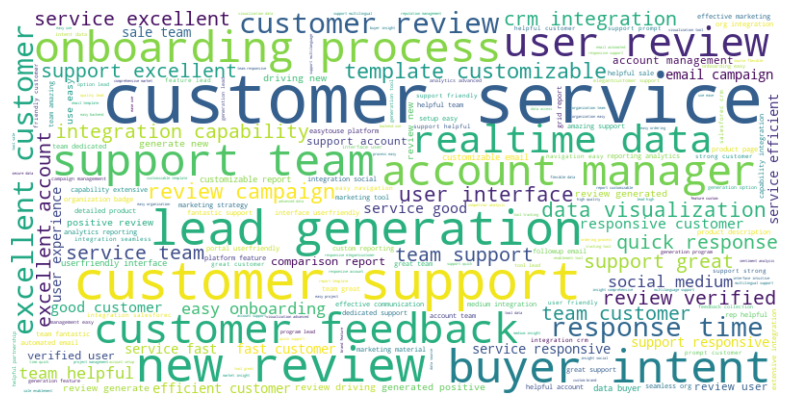

In [47]:
# Create an instance of G2ProductFeatureList with your token
g2 = G2ProductFeatureList(token)

# Call the time_features_extraction method with a date in RFC3339 format
rfc3339_date = "2000-01-01T00:00:00Z"  # Example date
g2.time_features_extraction(rfc3339_date)


In [48]:
len(g2.review_dict)

314